# Thoth: Software Stacks

This notebook is an experiment how to represent software stacks as a DAG within a bigger set of nodes/edges.

First of all we will include all the required modules and configure matplotlib to draw diagrams inlined in this notebook.

In [1]:
import json

import networkx as nx
from networkx.algorithms.operators.binary import compose
from networkx.readwrite import json_graph
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline

## Creating Graphs

Now we define a function that will read the output of `pipenv graph --json` from a file and create the equivalent graph using `networkx`.

In [2]:
import uuid


def add_package2(graph: nx.DiGraph, name: str, version: str) -> bool:
    """add_package2() will add a versioned package to the graph.
    
    Args:
        graph (networkx.Graph): the graph to add to
        name (str):             Name of the package
        version (str):          Version of the package
        
    Returns:
        str: the UUID of the node just added or None if something failed.
        
    Raises:
        TBD
    """
    
    _package_node_id = name.lower() # str(uuid.uuid4())
    _version_node_id = version # str(uuid.uuid4())

    graph.add_node(_package_node_id,
                   name=name,
                   component='package')
    graph.add_node(_version_node_id,
                   name=version,
                   version=version,
                   component='version')
    graph.add_edge(_package_node_id, _version_node_id, relation='has_version')
    
    # TODO check for errors and return None
    
    return (_package_node_id, _version_node_id)

def add_stack_from_file2(name: str, version: str, filename: str):
    """add_stack_from_file2() will read the output of `pipenv graph --json` and will create a networkx graph from it.
    
    Args:
        name (str):     Name of the Stack
        version (str):  Version of the Stack
        filename (str): The filename storing `pipenv graph --json` output
        
    Returns:
        networkx.Graph: The create graph.
        
    Raises:
        TBD
    """
    
    data = None
    G = None
    
    try:
        with open(filename) as file:    
            data = json.load(file)
    except FileNotFoundError as e:
        print(e)
        return None
        
    if data is not None:
        G = nx.DiGraph(name=name, version=version, component='stack')
        
        for package in data:
            _package_node_id, _version_node_id = add_package2(G, name=package['package']['package_name'], 
                        version=package['package']['installed_version'])
            
            for dependency in package['dependencies']:
                _dependency_package_node_id, _dependency_version_node_ = add_package2(G, name=dependency['package_name'], 
                            version=dependency['installed_version'])
                
                G.add_edge(_version_node_id, _dependency_version_node_, relation='depends_on')
                
    return G

We will read a set of files from the `fixtures/` directory:

In [3]:
PIPENV_GRAPH_FILES = [
    {
        'name': 'tensorflow',
        'version': '1.4.0',
        'filename': 'fixtures/tensorflow-1.4.0.json'
    }, 
    {
        'name': 'tensorflow',
        'version': '1.4.1',
        'filename': 'fixtures/tensorflow-1.4.1.json'
    },
    {
        'name': 'tensorflow',
        'version': '1.3.0',
        'filename': 'fixtures/tensorflow-1.3.0.json'
    },
    {
        'name': 'keras',
        'version': '2.1.2',
        'filename': 'fixtures/keras-2.1.2.json'
    },
    {
        'name': 'keras',
        'version': '2.1.2+tensorflow-1.3.0',
        'filename': 'fixtures/keras-2.1.2-tensorflow-1.3.0.json'
    }
]

Each file will be read and added to our big huge global graph store.

In [4]:
graph_store = []

for entry in PIPENV_GRAPH_FILES:
    _H = add_stack_from_file2(entry['name'], entry['version'], entry['filename'])
    
    if _H is not None:
        graph_store.append(_H)


The next cell will create on graph from all the graph in our `graph_store`. 

In [5]:
G = nx.DiGraph()

for _G in graph_store:
    G = nx.disjoint_union(G, _G)


Now that we have joint all the DAG into one huge graph, we need to identify package nodes having identical names and we need to unify them into a single node.

In [6]:
# This is a function to merge several nodes into one in a Networkx graph
# see https://gist.github.com/Zulko/7629206
def merge_nodes(G,nodes, new_node, attr_dict=None, **attr):
    """
    Merges the selected `nodes` of the graph G into one `new_node`,
    meaning that all the edges that pointed to or from one of these
    `nodes` will point to or from the `new_node`.
    attr_dict and **attr are defined as in `G.add_node`.
    """
    
    G.add_node(new_node, attr_dict, **attr) # Add the 'merged' node
    
    for n1,n2,data in G.edges(data=True):
        # For all edges related to one of the nodes to merge,
        # make an edge going to or coming from the `new gene`.
        if n1 in nodes:
            G.add_edge(new_node,n2,data)
        elif n2 in nodes:
            G.add_edge(n1,new_node,data)
    
    for n in nodes: # remove the merged nodes
        G.remove_node(n)

In [7]:
for n1,n2,data in G.edges(data=True):
    print('{}({}) {}({}) {}'.format(G.nodes[n1]['name'], n1, G.node[n2]['name'], n2, data))
    

werkzeug(0) 0.14.1(1) {'relation': 'has_version'}
tensorflow(2) 1.4.0(3) {'relation': 'has_version'}
1.4.0(3) 1.1.6(5) {'relation': 'depends_on'}
1.4.0(3) 1.11.0(7) {'relation': 'depends_on'}
1.4.0(3) 0.4.0rc3(9) {'relation': 'depends_on'}
1.4.0(3) 0.30.0(11) {'relation': 'depends_on'}
1.4.0(3) 1.14.0(13) {'relation': 'depends_on'}
1.4.0(3) 3.5.1(15) {'relation': 'depends_on'}
enum34(4) 1.1.6(5) {'relation': 'has_version'}
six(6) 1.11.0(7) {'relation': 'has_version'}
tensorflow-tensorboard(8) 0.4.0rc3(9) {'relation': 'has_version'}
0.4.0rc3(9) 1.11.0(7) {'relation': 'depends_on'}
0.4.0rc3(9) 2.6.11(17) {'relation': 'depends_on'}
0.4.0rc3(9) 0.9999999(19) {'relation': 'depends_on'}
0.4.0rc3(9) 0.30.0(11) {'relation': 'depends_on'}
0.4.0rc3(9) 0.14.1(1) {'relation': 'depends_on'}
0.4.0rc3(9) 1.14.0(13) {'relation': 'depends_on'}
0.4.0rc3(9) 1.5.0(21) {'relation': 'depends_on'}
0.4.0rc3(9) 3.5.1(15) {'relation': 'depends_on'}
wheel(10) 0.30.0(11) {'relation': 'has_version'}
numpy(12) 1.14

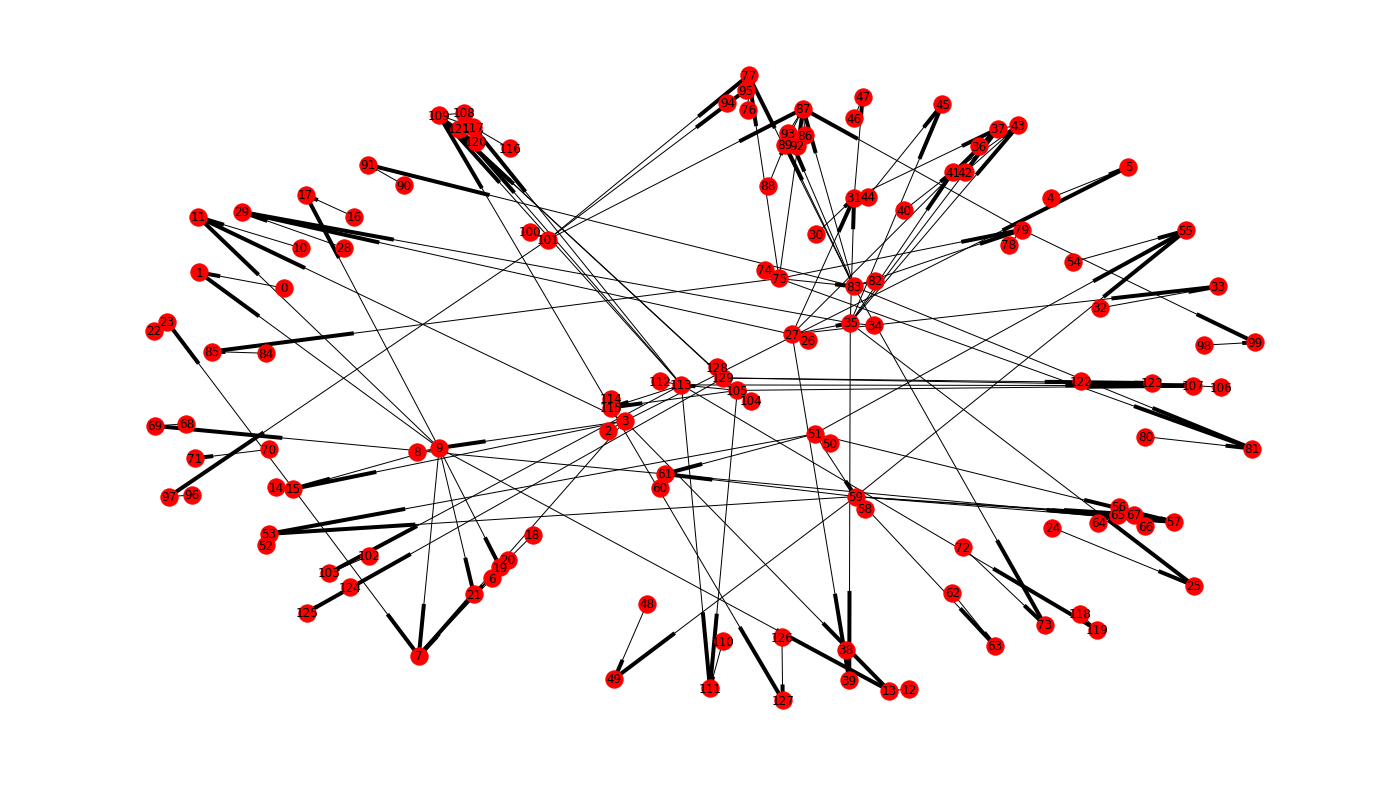

In [8]:

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5, forward=True)
nx.draw(G, with_labels=True)

... and here is the graph <a id='graph_drawing'></a>

{0: Text(0.803304,0.405704,'0'),
 1: Text(0.682011,0.347653,'1'),
 2: Text(-0.0766472,-0.247862,'2'),
 3: Text(-0.0663976,-0.390348,'3'),
 4: Text(-0.443629,-0.460741,'4'),
 5: Text(-0.869922,-0.670729,'5'),
 6: Text(0.279323,-0.0182072,'6'),
 7: Text(0.674768,-0.107171,'7'),
 8: Text(0.118837,-0.0612069,'8'),
 9: Text(0.209168,-0.244997,'9'),
 10: Text(-0.596349,-0.399377,'10'),
 11: Text(-0.75201,-0.605044,'11'),
 12: Text(-0.382145,-0.800369,'12'),
 13: Text(-0.314318,-0.841086,'13'),
 14: Text(0.633976,0.117249,'14'),
 15: Text(0.669697,0.0338485,'15'),
 16: Text(0.373181,0.0270961,'16'),
 17: Text(0.834493,-0.123426,'17'),
 18: Text(0.189921,-0.124106,'18'),
 19: Text(0.486561,-0.13959,'19'),
 20: Text(0.471696,-0.0299291,'20'),
 21: Text(0.557145,-0.119412,'21'),
 22: Text(0.328293,0.167104,'22'),
 23: Text(0.713897,0.173723,'23'),
 24: Text(0.505924,-0.43316,'24'),
 25: Text(0.729137,-0.6599,'25'),
 26: Text(0.0720019,0.299817,'26'),
 27: Text(0.0302325,0.217238,'27'),
 28: Text

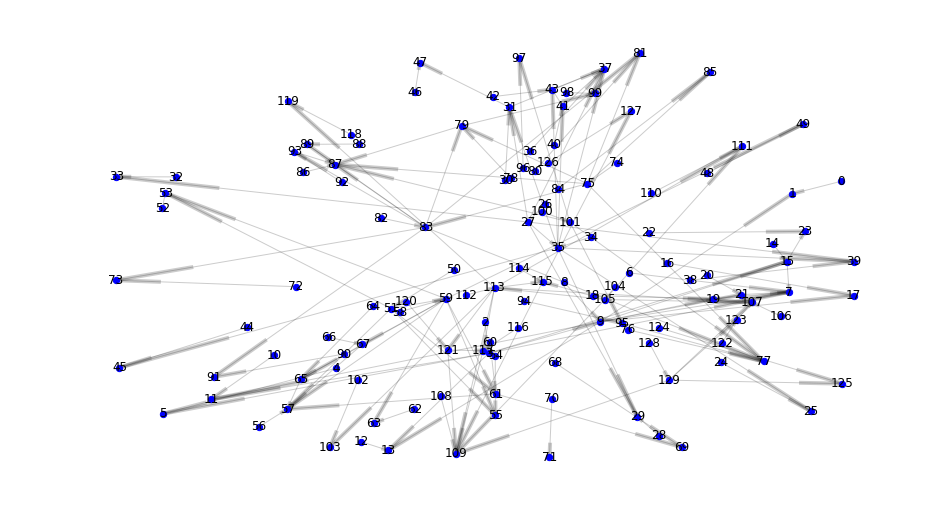

In [9]:
plt.figure(figsize=(16, 9))
plt.axis('off')

pos = nx.spring_layout(G, iterations=20)
labels=dict((n,d['name']) for n,d in G.nodes(data=True))

nx.draw_networkx_nodes(G, pos, labels=labels, node_size=40, node_color='blue')
nx.draw_networkx_edges(G, pos, alpha=0.2)
nx.draw_networkx_labels(G, pos, fontsize=10)

# Searching Packages

The `find_package_by_name()` function will search thru all the package nodes of the graph and compare the name... After joining all packages this should return exactly one package.

In [10]:
def find_package_by_name(name: str):
    this_is_it = []
    
    for (p, d) in G.nodes(data=True):
        if d['component'] != 'package':
            continue
        
        if d['name'] == name:
            this_is_it.append(G.nodes[p]) # this appends a dict()

    return this_is_it

nodes = find_package_by_name('six')

if len(nodes) > 0: 
    for n in nodes:
        print(type(n))

        print(n)

<class 'dict'>
{'name': 'six', 'component': 'package'}
<class 'dict'>
{'name': 'six', 'component': 'package'}
<class 'dict'>
{'name': 'six', 'component': 'package'}
<class 'dict'>
{'name': 'six', 'component': 'package'}
<class 'dict'>
{'name': 'six', 'component': 'package'}


## Writing the graph

... and the next cell is just for debugging...

Let's write the [JSON respresentation of the graph](https://networkx.github.io/documentation/stable/reference/readwrite/generated/networkx.readwrite.json_graph.node_link_data.html#networkx.readwrite.json_graph.node_link_data) to a file, so we can use it with d3.

In [11]:
with open('stacks.json', 'w') as output:
    data = json_graph.node_link_data(G)
    
    output.write(json.dumps(data))


## If everything worked out, you should see a graphic like the one below.
![Stacks](stacks-2.png)

Starting a simple Python http server will give us an opportunity to explore the whole graph by [clicking on this link](http://localhost:8000/stacks.html) 

**HINT**: Dont forget to interrupt the next cell if you want to continue in the notebook: `http.server` will block...

In [ ]:
!python -mhttp.server

Serving HTTP on 0.0.0.0 port 8000 (http://0.0.0.0:8000/) ...
127.0.0.1 - - [01/Jun/2018 09:29:32] "GET /stacks.json HTTP/1.1" 200 -
127.0.0.1 - - [01/Jun/2018 09:45:53] "GET /stacks.html HTTP/1.1" 200 -
127.0.0.1 - - [01/Jun/2018 09:45:53] "GET /stacks.json HTTP/1.1" 200 -
127.0.0.1 - - [01/Jun/2018 09:46:26] "GET /stacks.html HTTP/1.1" 200 -
127.0.0.1 - - [01/Jun/2018 09:46:26] "GET /stacks.json HTTP/1.1" 200 -
127.0.0.1 - - [01/Jun/2018 09:48:52] "GET /stacks.html HTTP/1.1" 200 -
127.0.0.1 - - [01/Jun/2018 09:48:52] "GET /stacks.json HTTP/1.1" 200 -
127.0.0.1 - - [01/Jun/2018 09:58:51] "GET /stacks.html HTTP/1.1" 200 -
127.0.0.1 - - [01/Jun/2018 09:58:51] "GET /stacks.json HTTP/1.1" 200 -
127.0.0.1 - - [01/Jun/2018 09:58:57] "GET /stacks.html HTTP/1.1" 200 -
127.0.0.1 - - [01/Jun/2018 10:10:15] "GET /stacks.html HTTP/1.1" 200 -
127.0.0.1 - - [01/Jun/2018 10:10:16] "GET /stacks.json HTTP/1.1" 200 -
